In [72]:
# !pip install opencv-python
# !pip install yattag
!pip install pandas

     ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/11.3 MB 1.3 MB/s eta 0:00:09
     --------------------------------------- 0.1/11.3 MB 871.5 kB/s eta 0:00:13
     --------------------------------------- 0.1/11.3 MB 798.9 kB/s eta 0:00:15
      --------------------------------------- 0.2/11.3 MB 1.4 MB/s eta 0:00:09
     - -------------------------------------- 0.3/11.3 MB 1.2 MB/s eta 0:00:10
     - -------------------------------------- 0.5/11.3 MB 1.8 MB/s eta 0:00:06
     - -------------------------------------- 0.6/11.3 MB 1.9 MB/s eta 0:00:06
     --- ------------------------------------ 0.9/11.3 MB 2.3 MB/s eta 0:00:05
     ---- ----------------------------------- 1.2/11.3 MB 2.9 MB/s eta 0:00:04
     ----- ---------------------------------- 1.4/11.3 MB 3.1 MB/s eta 0:00:04
     ------ --------------------------------- 1.9/11.3 MB 3.7 MB/s eta 0:00:03
     ------- -------------------------------- 2.1/11.3 MB


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# ============================================= 
# Q-Learning for SnakeGame (Full Training, 3000 episodes)
# Metrics: Sample Efficiency, Exploration, Runtime, Convergence & Stability, Policy Behavior
# Includes gameplay recording of best episode
# =============================================

import numpy as np
import random
import time
import matplotlib.pyplot as plt
from collections import defaultdict, deque
from snake_gym.envs import snake
from snake_gym.envs.modules import UP, DOWN, LEFT, RIGHT
import cv2
import warnings
warnings.filterwarnings("ignore")  # ⚙️ Keep output clean during long runs

pygame 2.6.1 (SDL 2.28.4, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# -----------------------
# 1. Environment Setup
# -----------------------
env = snake.SnakeGame()
n_actions = 4  # 0: UP, 1: DOWN, 2: LEFT, 3: RIGHT
dir_to_int = {UP:0, DOWN:1, LEFT:2, RIGHT:3}

In [4]:
# -----------------------
# 2. State Representation
# -----------------------
def get_state(env):
    """Simplified symbolic state: (dx, dy, direction)"""
    head_x, head_y = env.snake.get_head_position()
    apple_x, apple_y = env.apple.position
    dx = np.sign(apple_x - head_x)
    dy = np.sign(apple_y - head_y)
    direction = dir_to_int[env.snake.direction]
    return (dx, dy, direction)

In [5]:
# -----------------------
# 3. Hyperparameters
# -----------------------
episodes = 3000  # ⏳ Full training run
alpha = 0.1
gamma = 0.9
epsilon_init = 1.0
epsilon_decay = 0.995
epsilon_min = 0.05

In [6]:
# -----------------------
# 4. Multi-run Setup for Convergence
# -----------------------
seeds = [42, 123, 999]
all_rewards = []
all_epsilons = []
all_steps = []
runtime_per_seed = []

In [7]:
# import pickle
# from collections import defaultdict

# seed = 999
# checkpoint_file = f"q_table_seed_{seed}.pkl"

# with open(checkpoint_file, "rb") as f:
#     Q = pickle.load(f)
# Q = defaultdict(lambda: np.zeros(n_actions), Q)

# start_episode = 3900
# epsilon = max(epsilon_min, epsilon_init * (epsilon_decay ** start_episode))


In [8]:
# -----------------------
# 5. Training Loop with Metrics Saving
# -----------------------
import pickle

for seed in seeds:
    random.seed(seed)
    np.random.seed(seed)
    
    Q = defaultdict(lambda: np.zeros(n_actions))
    rewards_per_episode = []
    moving_avg_rewards = deque(maxlen=10)
    epsilons = []
    steps_per_episode = []
    
    epsilon = epsilon_init
    start_time = time.time()
    
    for episode in range(episodes):
        env.reset()
        state = get_state(env)
        done = False
        total_reward = 0
        steps = 0
        
        while not done:
            if random.random() < epsilon:
                action = random.choice(range(n_actions))
            else:
                action = np.argmax(Q[state])
            
            next_state_img, reward, done, _ = env.step(action)
            next_state = get_state(env)
            
            Q[state][action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state][action])
            state = next_state
            total_reward += reward
            steps += 1
        
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards_per_episode.append(total_reward)
        moving_avg_rewards.append(total_reward)
        epsilons.append(epsilon)
        steps_per_episode.append(steps)
        
        # Progress printing
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(moving_avg_rewards)
            print(f"Seed {seed} | Episode {episode+1}/{episodes} | Avg Reward (last {len(moving_avg_rewards)}): {avg_reward:.2f} | ε={epsilon:.3f}")
        
        # Checkpoint & metrics saving every 1000 episodes
        if (episode + 1) % 1000 == 0:
            with open(f"checkpoint_seed_{seed}_ep_{episode+1}.pkl", "wb") as f:
                pickle.dump(dict(Q), f)
            with open(f"rewards_seed_{seed}_ep_{episode+1}.pkl", "wb") as f:
                pickle.dump(rewards_per_episode, f)
            with open(f"epsilons_seed_{seed}_ep_{episode+1}.pkl", "wb") as f:
                pickle.dump(epsilons, f)
            with open(f"steps_seed_{seed}_ep_{episode+1}.pkl", "wb") as f:
                pickle.dump(steps_per_episode, f)
            print(f"💾 Checkpoint & metrics saved at episode {episode+1}")
    
    end_time = time.time()
    total_time = end_time - start_time
    avg_time_per_episode = total_time / episodes
    print(f"\nSeed {seed} | Total Training Time: {total_time:.2f}s | Avg per episode: {avg_time_per_episode:.3f}s\n")
    
    all_rewards.append(rewards_per_episode)
    all_epsilons.append(epsilons)
    all_steps.append(steps_per_episode)
    runtime_per_seed.append(avg_time_per_episode)

    # Save final Q-table and metrics
    with open(f"q_table_seed_{seed}.pkl", "wb") as f:
        pickle.dump(dict(Q), f)
    with open(f"rewards_seed_{seed}.pkl", "wb") as f:
        pickle.dump(rewards_per_episode, f)
    with open(f"epsilons_seed_{seed}.pkl", "wb") as f:
        pickle.dump(epsilons, f)
    with open(f"steps_seed_{seed}.pkl", "wb") as f:
        pickle.dump(steps_per_episode, f)
    print(f"✅ Final Q-table & metrics saved for seed {seed}")


Seed 42 | Episode 100/3000 | Avg Reward (last 10): 4.77 | ε=0.606
Seed 42 | Episode 200/3000 | Avg Reward (last 10): 30.01 | ε=0.367
Seed 42 | Episode 300/3000 | Avg Reward (last 10): 37.33 | ε=0.222
Seed 42 | Episode 400/3000 | Avg Reward (last 10): 58.02 | ε=0.135
Seed 42 | Episode 500/3000 | Avg Reward (last 10): 48.17 | ε=0.082
Seed 42 | Episode 600/3000 | Avg Reward (last 10): 64.80 | ε=0.050
Seed 42 | Episode 700/3000 | Avg Reward (last 10): 72.17 | ε=0.050
Seed 42 | Episode 800/3000 | Avg Reward (last 10): 54.07 | ε=0.050
Seed 42 | Episode 900/3000 | Avg Reward (last 10): 70.53 | ε=0.050
Seed 42 | Episode 1000/3000 | Avg Reward (last 10): 76.50 | ε=0.050
💾 Checkpoint & metrics saved at episode 1000
Seed 42 | Episode 1100/3000 | Avg Reward (last 10): 37.36 | ε=0.050
Seed 42 | Episode 1200/3000 | Avg Reward (last 10): 51.90 | ε=0.050
Seed 42 | Episode 1300/3000 | Avg Reward (last 10): 50.73 | ε=0.050
Seed 42 | Episode 1400/3000 | Avg Reward (last 10): 66.63 | ε=0.050
Seed 42 | Epi

In [9]:
# with open(f"rewards_seed_{seed}_resumed.pkl", "wb") as f:
#     pickle.dump(all_rewards[0], f)
# with open(f"epsilons_seed_{seed}_resumed.pkl", "wb") as f:
#     pickle.dump(all_epsilons[0], f)
# with open(f"steps_seed_{seed}_resumed.pkl", "wb") as f:
#     pickle.dump(all_steps[0], f)
# print("✅ Resumed metrics saved.")

In [10]:
# import pickle
# import matplotlib.pyplot as plt

# # -----------------------------
# # Load old metrics (before interruption)
# # -----------------------------
# seed = 999
# with open(f"rewards_seed_{seed}.pkl", "rb") as f:
#     old_rewards = pickle.load(f)
# with open(f"epsilons_seed_{seed}.pkl", "rb") as f:
#     old_epsilons = pickle.load(f)
# with open(f"steps_seed_{seed}.pkl", "rb") as f:
#     old_steps = pickle.load(f)

# # -----------------------------
# # Merge with resumed metrics
# # -----------------------------
# full_rewards = old_rewards + all_rewards[0]   # all_rewards from resumed loop
# full_epsilons = old_epsilons + all_epsilons[0]
# full_steps = old_steps + all_steps[0]

# # -----------------------------
# # Plotting
# # -----------------------------
# plt.figure(figsize=(10,4))
# plt.plot(range(1, len(full_rewards)+1), full_rewards, label="Total Reward per Episode")
# plt.xlabel("Episode")
# plt.ylabel("Reward")
# plt.title(f"Seed {seed} - Total Rewards (Full Training)")
# plt.legend()
# plt.show()

# plt.figure(figsize=(10,4))
# plt.plot(range(1, len(full_epsilons)+1), full_epsilons, label="Epsilon")
# plt.xlabel("Episode")
# plt.ylabel("Epsilon Value")
# plt.title(f"Seed {seed} - Epsilon Decay (Full Training)")
# plt.legend()
# plt.show()

# plt.figure(figsize=(10,4))
# plt.plot(range(1, len(full_steps)+1), full_steps, label="Steps per Episode")
# plt.xlabel("Episode")
# plt.ylabel("Steps")
# plt.title(f"Seed {seed} - Steps per Episode (Full Training)")
# plt.legend()
# plt.show()


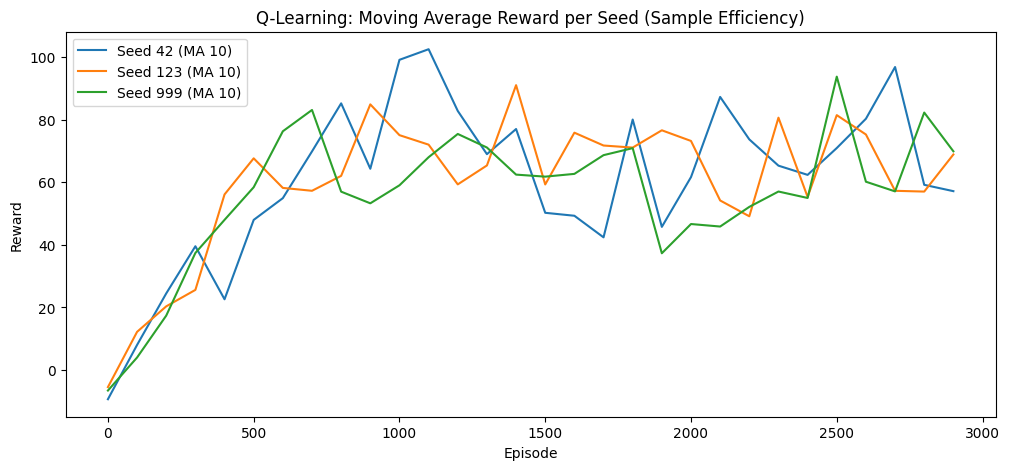

Episodes to reach 50%, 80%, 90% of max reward per seed:
Seed 42: {'50%': 364, '80%': 681, '90%': 686}
Seed 123: {'50%': 383, '80%': 685, '90%': 1352}
Seed 999: {'50%': 383, '80%': 827, '90%': 945}


In [66]:
# -----------------------
# 6. Sample Efficiency
# -----------------------
import numpy as np
import matplotlib.pyplot as plt

ma_window = 10  # moving average window
downsample = 100  # plot every 50 episodes

# For storing episode numbers to reach thresholds
episodes_to_thresholds = {seed: {} for seed in seeds}
thresholds = [0.5, 0.8, 0.9]  # 50%, 80%, 90%

plt.figure(figsize=(12,5))

for i, rewards in enumerate(all_rewards):
    # Compute moving average
    if len(rewards) < ma_window:
        ma = np.array(rewards)
    else:
        ma = np.convolve(rewards, np.ones(ma_window)/ma_window, mode='valid')
    
    max_reward = np.max(ma)
    
    # Find first episode reaching each threshold
    for t in thresholds:
        target = t * max_reward
        episode_idx = next((idx for idx, r in enumerate(ma) if r >= target), None)
        episodes_to_thresholds[seeds[i]][f"{int(t*100)}%"] = episode_idx
    
    # Downsample for plotting
    x = np.arange(len(ma))
    x_ds = x[::downsample]
    ma_ds = ma[::downsample]
    
    plt.plot(x_ds, ma_ds, label=f"Seed {seeds[i]} (MA {ma_window})")

plt.title("Q-Learning: Moving Average Reward per Seed (Sample Efficiency)")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()

# Print summary table
print("Episodes to reach 50%, 80%, 90% of max reward per seed:")
for seed, data in episodes_to_thresholds.items():
    print(f"Seed {seed}: {data}")


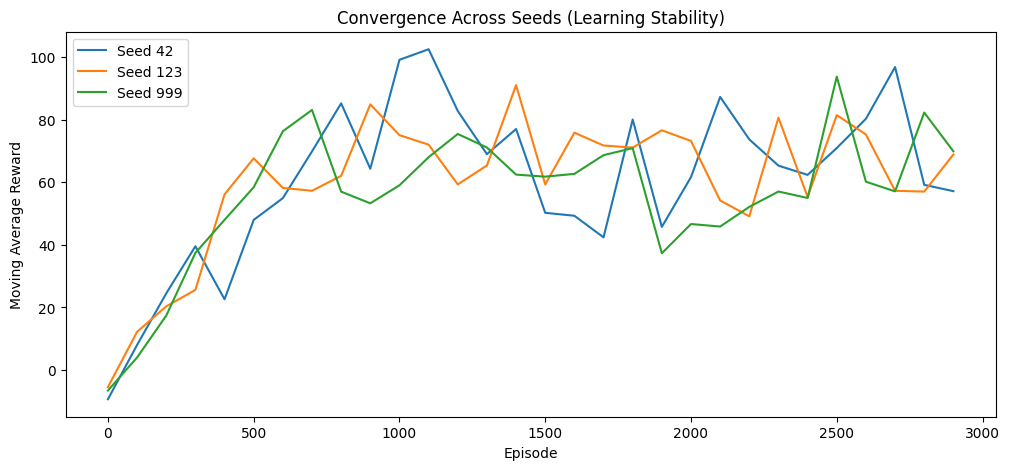

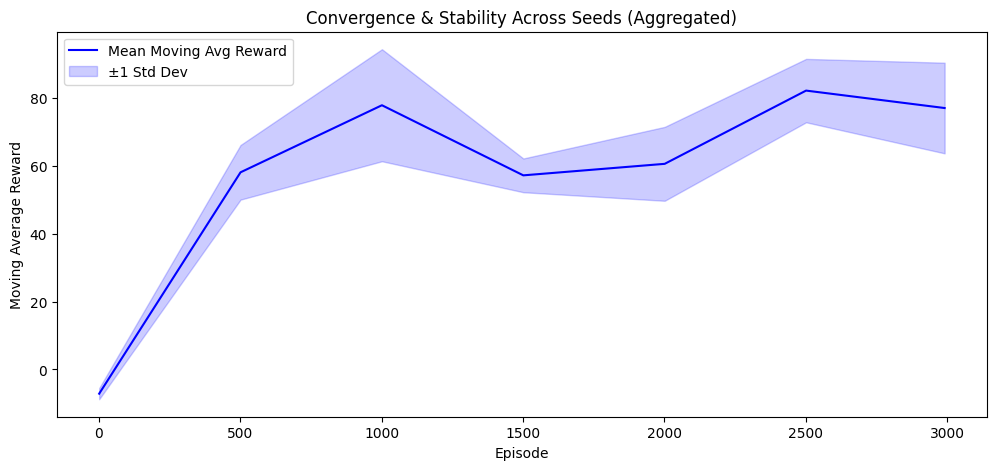

Convergence & Stability Table (Exact Downsampled Values):
      Seed 42  Seed 123  Seed 999   Mean  StdDev
1       -9.35     -5.48     -6.58  -7.14    1.63
501     47.99     67.67     58.43  58.03    8.04
1001    99.18     75.09     59.05  77.77   16.49
1501    50.26     59.32     61.82  57.13    4.97
2001    61.67     73.23     46.67  60.52   10.88
2501    70.97     81.49     93.80  82.08    9.33
2991    95.82     67.46     67.57  76.95   13.34


In [78]:
# -----------------------
# 7. Convergence & Stability Visualization
# -----------------------
import numpy as np
import matplotlib.pyplot as plt

ma_window = 10
downsample = 100  # plot every 50 episodes

# -----------------------
# Convergence Across Seeds
# -----------------------
plt.figure(figsize=(12,5))
for i, rewards in enumerate(all_rewards):
    ma = np.convolve(rewards, np.ones(ma_window)/ma_window, mode='valid')
    x = np.arange(len(ma))
    x_ds = x[::downsample]
    ma_ds = ma[::downsample]
    plt.plot(x_ds, ma_ds, label=f"Seed {seeds[i]}")

plt.title("Convergence Across Seeds (Learning Stability)")
plt.xlabel("Episode")
plt.ylabel("Moving Average Reward")
plt.legend()
plt.show()



ma_window = 10  # moving average
downsample = 500  # only plot every 50 episodes for clarity

# Compute moving averages per seed
all_ma = []
for rewards in all_rewards:
    if len(rewards) < ma_window:
        ma = np.array(rewards)
    else:
        ma = np.convolve(rewards, np.ones(ma_window)/ma_window, mode='valid')
    all_ma.append(ma)

min_len = min(len(ma) for ma in all_ma)
x_ds = np.arange(0, min_len, downsample)

# Ensure last episode is included
if (min_len-1) not in x_ds:
    x_ds = np.append(x_ds, min_len-1)

all_ma_trunc = [ma[x_ds] for ma in all_ma]
episodes_axis_ds = x_ds + 1  # 1-indexed

# Aggregate
mean_ma = np.mean(all_ma_trunc, axis=0)
std_ma = np.std(all_ma_trunc, axis=0)

# Plot
plt.figure(figsize=(12,5))
plt.plot(episodes_axis_ds, mean_ma, label="Mean Moving Avg Reward", color="blue")
plt.fill_between(episodes_axis_ds, mean_ma - std_ma, mean_ma + std_ma,
                 color="blue", alpha=0.2, label="±1 Std Dev")
plt.title("Convergence & Stability Across Seeds (Aggregated)")
plt.xlabel("Episode")
plt.ylabel("Moving Average Reward")
plt.legend()
plt.show()

# -----------------------
# 7c. Convergence & Stability Table (Exact Values)
# -----------------------
import pandas as pd

# Build a table for downsampled episodes
table_data = {}

# Add each seed's downsampled MA
for i, seed in enumerate(seeds):
    table_data[f"Seed {seed}"] = all_ma_trunc[i]

# Add aggregated mean and std dev
table_data["Mean"] = mean_ma
table_data["StdDev"] = std_ma

# Create DataFrame with episode numbers as index
df_convergence = pd.DataFrame(table_data, index=episodes_axis_ds)

# Display table with 2 decimal precision
pd.set_option('display.precision', 2)
print("Convergence & Stability Table (Exact Downsampled Values):")
print(df_convergence)



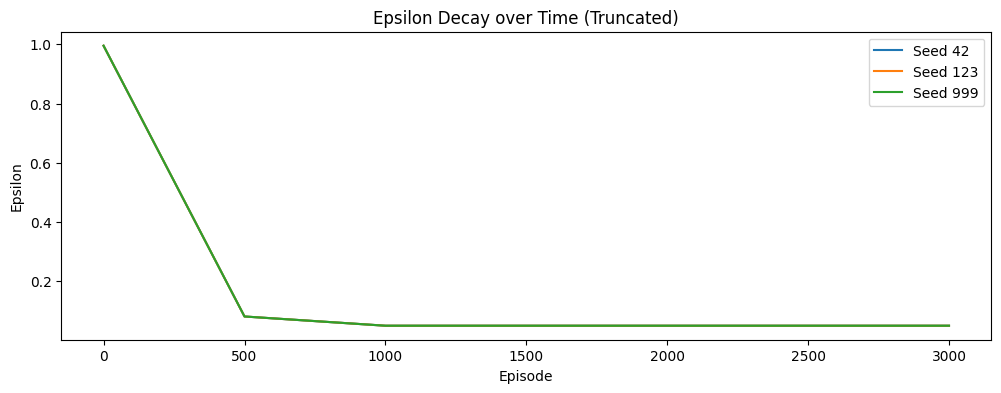


Epsilon Decay Table (Truncated up to 3000):
   Episode  Seed 42  Seed 123  Seed 999
0        0     0.99      0.99      0.99
1      500     0.08      0.08      0.08
2     1000     0.05      0.05      0.05
3     1500     0.05      0.05      0.05
4     2000     0.05      0.05      0.05
5     2500     0.05      0.05      0.05
6     2999     0.05      0.05      0.05


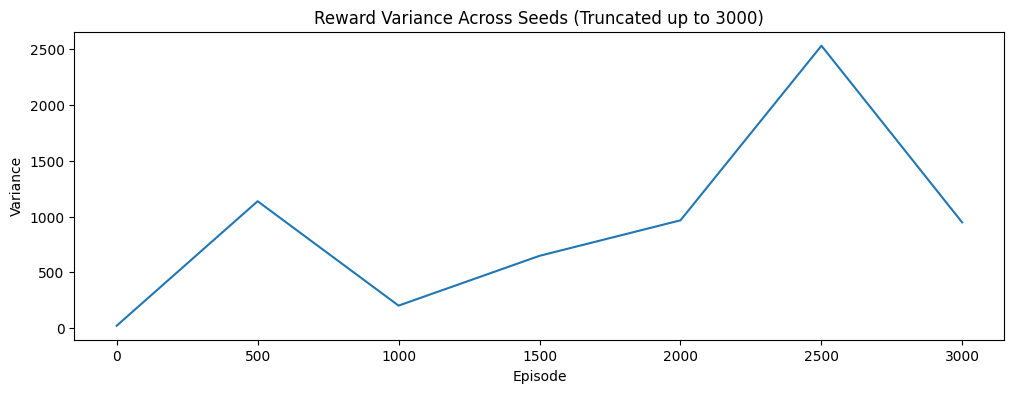


Reward Variance Table (Truncated up to 3000):
   Episode  Reward Variance
0        0            21.82
1      500          1137.72
2     1000           202.08
3     1500           648.34
4     2000           966.79
5     2500          2531.71
6     2999           948.41


In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# 8. Exploration Stability (Truncated)
# -----------------------

truncate_every = 500  # show every 500th episode/block
max_episode = 3000    # ensure table and plots go up to episode 3000

# --- Epsilon Decay (Truncated) ---
plt.figure(figsize=(12,4))
eps_tables = []
for i, eps in enumerate(all_epsilons):
    eps_trunc = eps[::truncate_every]
    # Make sure last episode (3000) is included
    if len(eps) >= max_episode and (max_episode-1) not in np.arange(0, len(eps), truncate_every):
        eps_trunc = np.append(eps_trunc, eps[max_episode-1])
    eps_table = pd.DataFrame({
        "Episode": np.arange(0, len(eps), truncate_every).tolist() + ([max_episode-1] if len(eps_trunc) > len(np.arange(0, len(eps), truncate_every)) else []),
        f"Seed {seeds[i]}": eps_trunc
    })
    eps_tables.append(eps_table)
    plt.plot(eps_table["Episode"], eps_trunc, label=f"Seed {seeds[i]}")
plt.title("Epsilon Decay over Time (Truncated)")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.legend()
plt.show()

# Merge all epsilon tables into a single table
epsilon_df = eps_tables[0]
for tbl in eps_tables[1:]:
    epsilon_df = pd.merge(epsilon_df, tbl, on="Episode")
print("\nEpsilon Decay Table (Truncated up to 3000):")
print(epsilon_df)

# --- Reward Variance Across Seeds (Truncated) ---
max_len = max(len(r) for r in all_rewards)
padded_rewards = [np.pad(r, (0, max_len - len(r)), 'edge') for r in all_rewards]
reward_variance_across_seeds = np.var(padded_rewards, axis=0)

# Downsample for plotting and table, including last episode
downsample = 500
x_var = np.arange(len(reward_variance_across_seeds))
x_var_ds = x_var[::downsample].tolist()
if len(x_var) >= max_episode and (max_episode-1) not in x_var_ds:
    x_var_ds.append(max_episode-1)
var_ds = reward_variance_across_seeds[x_var_ds]

plt.figure(figsize=(12,4))
plt.plot(x_var_ds, var_ds)
plt.title("Reward Variance Across Seeds (Truncated up to 3000)")
plt.xlabel("Episode")
plt.ylabel("Variance")
plt.show()

# Create table
reward_var_table = pd.DataFrame({
    "Episode": x_var_ds,
    "Reward Variance": var_ds
})
print("\nReward Variance Table (Truncated up to 3000):")
print(reward_var_table)


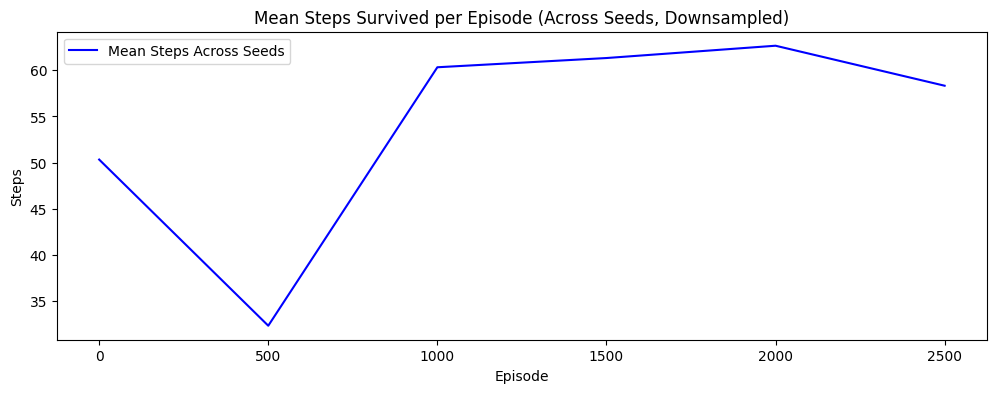


Policy Behavior Table (Mean Steps Across Seeds, Downsampled every 500 episodes):
   Episode  Mean Steps
0        0       50.33
1      500       32.33
2     1000       60.33
3     1500       61.33
4     2000       62.67
5     2500       58.33


In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# 9. Policy Behavior (Steps Survived) - Downsampled
# -----------------------

downsample = 500  # show every 500th episode
plt.figure(figsize=(12,4))

# Collect downsampled steps across seeds
all_steps_ds = []

for steps in all_steps:
    steps_ds = steps[::downsample]
    all_steps_ds.append(steps_ds)

# Convert to numpy array for easy mean calculation
all_steps_ds = np.array(all_steps_ds)  # shape: (num_seeds, num_downsampled_points)
mean_steps = np.mean(all_steps_ds, axis=0)

# X-axis episodes
episodes_ds = np.arange(0, len(all_steps[0]), downsample)

# Plot mean only
plt.plot(episodes_ds, mean_steps, label="Mean Steps Across Seeds", color="blue")
plt.title("Mean Steps Survived per Episode (Across Seeds, Downsampled)")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.legend()
plt.show()

# Prepare table
policy_behavior_mean_table = pd.DataFrame({
    "Episode": episodes_ds,
    "Mean Steps": mean_steps
})

print("\nPolicy Behavior Table (Mean Steps Across Seeds, Downsampled every 500 episodes):")
print(policy_behavior_mean_table)


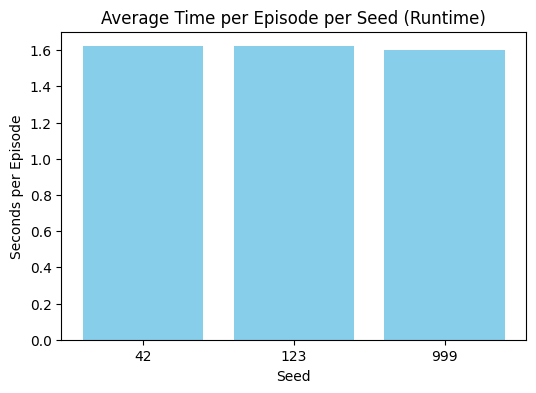


Runtime Table (Average Time per Episode per Seed):
   Seed  Avg Time per Episode (s)
0    42                      1.62
1   123                      1.62
2   999                      1.60


In [103]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------
# 10. Runtime / Computational Efficiency
# -----------------------

# Plot bar chart
plt.figure(figsize=(6,4))
plt.bar([str(s) for s in seeds], runtime_per_seed, color='skyblue')
plt.title("Average Time per Episode per Seed (Runtime)")
plt.xlabel("Seed")
plt.ylabel("Seconds per Episode")
plt.show()

# Create table
runtime_table = pd.DataFrame({
    "Seed": seeds,
    "Avg Time per Episode (s)": runtime_per_seed
})

print("\nRuntime Table (Average Time per Episode per Seed):")
print(runtime_table)


In [107]:
# -----------------------
# High-Level Summary Report (HTML) - Q-Learning
# -----------------------
from yattag import Doc, indent
import numpy as np
import pandas as pd

html_report = "snake_qlearning_summary.html"
doc, tag, text, line = Doc().ttl()

# Compute per-seed metrics
episodes_to_thresholds = []
mean_rewards = []
std_rewards = []
final_epsilons = []
avg_steps = []
avg_runtime = []
raw_max_rewards = []
raw_max_episodes = []
ma_max_rewards = []
ma_max_episodes = []

ma_window = 10  # moving average window

for i, rewards in enumerate(all_rewards):
    # Moving average
    if len(rewards) < ma_window:
        ma = np.array(rewards)
    else:
        ma = np.convolve(rewards, np.ones(ma_window)/ma_window, mode='valid')

    max_reward_ma = np.max(ma)
    episode_ma = np.argmax(ma) + 1  # +1 if 1-indexed

    max_reward_raw = np.max(rewards)
    episode_raw = np.argmax(rewards) + 1

    # Threshold episodes
    eps_to_50 = next((idx for idx, r in enumerate(ma) if r >= 0.5*max_reward_ma), "N/A")
    eps_to_80 = next((idx for idx, r in enumerate(ma) if r >= 0.8*max_reward_ma), "N/A")
    eps_to_90 = next((idx for idx, r in enumerate(ma) if r >= 0.9*max_reward_ma), "N/A")
    episodes_to_thresholds.append((eps_to_50, eps_to_80, eps_to_90))

    mean_rewards.append(np.mean(rewards))
    std_rewards.append(np.std(rewards))
    final_epsilons.append(all_epsilons[i][-1])
    avg_steps.append(np.mean(all_steps[i]))
    avg_runtime.append(runtime_per_seed[i])
    raw_max_rewards.append(max_reward_raw)
    raw_max_episodes.append(episode_raw)
    ma_max_rewards.append(max_reward_ma)
    ma_max_episodes.append(episode_ma)

# Best seed by moving average reward
best_seed_idx = np.argmax(ma_max_rewards)
best_seed = seeds[best_seed_idx]
best_ma_reward = ma_max_rewards[best_seed_idx]
best_ma_episode = ma_max_episodes[best_seed_idx]

# Build HTML
with tag('html'):
    with tag('head'):
        line('title', 'Snake Q-Learning High-Level Summary')
        with tag('style'):
            text("""
                table {border-collapse: collapse; width: 80%;}
                th, td {padding: 8px; text-align: center; border: 1px solid black;}
                th {background-color: #f2f2f2;}
                h1, h2 {font-family: Arial, sans-serif;}
            """)
    with tag('body'):
        line('h1', 'Snake Q-Learning High-Level Summary Report')

        # Best seed info
        with tag('h2'):
            text(f"Best Seed by Moving Average Max Reward: Seed {best_seed} | Max MA Reward = {best_ma_reward:.2f} at Episode {best_ma_episode}")

        # Per-seed summary table
        with tag('h2'):
            text("Per-Seed Key Metrics")
        with tag('table'):
            with tag('tr'):
                for col in ["Seed", "Episodes to 50% / 80% / 90% Max Reward",
                            "Mean Reward", "Std Dev Reward", "Final Epsilon",
                            "Avg Steps Survived", "Avg Runtime/Episode (s)",
                            "Raw Max Reward", "Episode of Raw Max Reward",
                            "MA Max Reward", "Episode of MA Max Reward"]:
                    line('th', col)
            for i, seed in enumerate(seeds):
                with tag('tr'):
                    line('td', seed)
                    line('td', f"{episodes_to_thresholds[i][0]} / {episodes_to_thresholds[i][1]} / {episodes_to_thresholds[i][2]}")
                    line('td', f"{mean_rewards[i]:.2f}")
                    line('td', f"{std_rewards[i]:.2f}")
                    line('td', f"{final_epsilons[i]:.3f}")
                    line('td', f"{avg_steps[i]:.2f}")
                    line('td', f"{avg_runtime[i]:.3f}")
                    line('td', f"{raw_max_rewards[i]:.2f}")
                    line('td', f"{raw_max_episodes[i]}")
                    line('td', f"{ma_max_rewards[i]:.2f}")
                    line('td', f"{ma_max_episodes[i]}")

        # Aggregate metrics
        with tag('h2'):
            text("Aggregate Metrics Across Seeds")
        with tag('table'):
            with tag('tr'):
                for col in ["Metric", "Value"]:
                    line('th', col)
            metrics = {
                "Mean of Mean Rewards": np.mean(mean_rewards),
                "Std Dev of Mean Rewards": np.std(mean_rewards),
                "Mean Final Epsilon": np.mean(final_epsilons),
                "Mean Avg Steps Survived": np.mean(avg_steps),
                "Mean Runtime per Episode (s)": np.mean(avg_runtime),
                "Mean Raw Max Reward": np.mean(raw_max_rewards),
                "Mean MA Max Reward": np.mean(ma_max_rewards)
            }
            for k, v in metrics.items():
                with tag('tr'):
                    line('td', k)
                    line('td', f"{v:.3f}")

# Save HTML
with open(html_report, "w") as f:
    f.write(indent(doc.getvalue()))

print(f"✅ High-Level HTML summary report saved as '{html_report}'")


✅ High-Level HTML summary report saved as 'snake_qlearning_summary.html'


In [109]:
# -----------------------
# Post-Training Evaluation (Greedy Policy) + Combined Video
# -----------------------
import numpy as np
import pickle
import os
import cv2

# 🧠 Load the trained Q-table
seed_to_evaluate = 999  # change this to your best-performing seed
with open(f"q_table_seed_{seed_to_evaluate}.pkl", "rb") as f:
    Q = pickle.load(f)

# 🎞️ Create output directory
video_dir = f"final_videos_seed_{seed_to_evaluate}"
os.makedirs(video_dir, exist_ok=True)

eval_episodes = 10
eval_rewards = []
all_frames = []  # will hold frames from all 10 episodes

print(f"\n🎯 Evaluating trained policy for seed {seed_to_evaluate} (greedy)...\n")

for ep in range(eval_episodes):
    env.reset()
    state = get_state(env)
    done = False
    total_reward = 0
    frames = []

    while not done:
        # purely greedy — no epsilon
        action = np.argmax(Q[state])
        frame, reward, done, _ = env.step(action)
        frames.append(frame)
        state = get_state(env)
        total_reward += reward

    eval_rewards.append(total_reward)
    print(f"Eval Episode {ep+1}: Reward = {total_reward:.2f}")

    # Add a short pause (10 black frames) between episodes for clarity
    all_frames.extend(frames)
    pause_frame = np.zeros_like(frames[0])
    all_frames.extend([pause_frame] * 10)

# 💾 Save all episodes into one stitched video
if len(all_frames) > 0:
    height, width, _ = all_frames[0].shape
    video_filename = os.path.join(video_dir, f"combined_eval_seed_{seed_to_evaluate}.avi")
    out = cv2.VideoWriter(video_filename, cv2.VideoWriter_fourcc(*'XVID'), 15, (width, height))

    for f in all_frames:
        if f.shape[2] == 4:  # convert RGBA → BGR if needed
            f = cv2.cvtColor(f, cv2.COLOR_RGBA2BGR)
        out.write(f)
    out.release()

# 📊 Save evaluation results
with open(f"eval_rewards_seed_{seed_to_evaluate}.pkl", "wb") as f:
    pickle.dump(eval_rewards, f)

avg_eval_reward = np.mean(eval_rewards)
print(f"\n✅ Average Evaluation Reward (no exploration): {avg_eval_reward:.2f}")
print(f"🎥 Combined video saved at: {video_filename}\n")


🎯 Evaluating trained policy for seed 999 (greedy)...

Eval Episode 1: Reward = 189.08
Eval Episode 2: Reward = 85.58
Eval Episode 3: Reward = 0.53
Eval Episode 4: Reward = 84.29
Eval Episode 5: Reward = 63.05
Eval Episode 6: Reward = 147.68
Eval Episode 7: Reward = 86.06
Eval Episode 8: Reward = 170.48
Eval Episode 9: Reward = 167.57
Eval Episode 10: Reward = 31.76

✅ Average Evaluation Reward (no exploration): 102.61
🎥 Combined video saved at: final_videos_seed_999\combined_eval_seed_999.avi



In [57]:
# # -----------------------
# # Post-Training Evaluation (Greedy Policy) + Video Recording
# # -----------------------
# import numpy as np
# import pickle
# import os
# import cv2

# # Load the trained Q-table
# seed_to_evaluate = 123  # change this to the seed you want
# with open(f"q_table_seed_{seed_to_evaluate}.pkl", "rb") as f:
#     Q = pickle.load(f)

# video_dir = f"1videos_seed_{seed_to_evaluate}"
# os.makedirs(video_dir, exist_ok=True)

# eval_episodes = 10
# eval_rewards = []

# print(f"\n🎯 Evaluating trained policy for seed {seed_to_evaluate} (greedy)...\n")

# for ep in range(eval_episodes):
#     env.reset()
#     state = get_state(env)
#     done = False
#     total_reward = 0
#     steps = 0
#     frames = []

#     while not done:
#         # purely greedy — no epsilon
#         action = np.argmax(Q[state])
#         frame, reward, done, _ = env.step(action)
#         frames.append(frame)
#         state = get_state(env)
#         total_reward += reward
#         steps += 1

#     eval_rewards.append(total_reward)
#     print(f"Eval Episode {ep+1}: Reward = {total_reward}")
    
#     # Save video for this episode
#     if len(frames) > 0:
#         height, width, _ = frames[0].shape
#         video_filename = os.path.join(video_dir, f"episode_{ep+1}_reward_{total_reward}.avi")
#         out = cv2.VideoWriter(video_filename, cv2.VideoWriter_fourcc(*'XVID'), 15, (width, height))
#         for f in frames:
#             if f.shape[2] == 4:
#                 f = cv2.cvtColor(f, cv2.COLOR_RGBA2BGR)
#             out.write(f)
#         out.release()

# # Save evaluation results
# with open(f"eval_rewards_seed{seed_to_evaluate}.pkl", "wb") as f:
#     pickle.dump(eval_rewards, f)

# avg_eval_reward = np.mean(eval_rewards)
# print(f"\n✅ Average Evaluation Reward (no exploration): {avg_eval_reward:.2f}")
# print(f"🎥 {eval_episodes} video recordings saved in: {video_dir}\n")


🎯 Evaluating trained policy for seed 123 (greedy)...

Eval Episode 1: Reward = 72.59000000000005
Eval Episode 2: Reward = 128.1500000000002
Eval Episode 3: Reward = 94.97000000000014
Eval Episode 4: Reward = 82.34000000000006
Eval Episode 5: Reward = 115.1300000000001
Eval Episode 6: Reward = 83.69000000000007
Eval Episode 7: Reward = 73.9100000000001
Eval Episode 8: Reward = 115.64000000000013
Eval Episode 9: Reward = 83.15000000000006
Eval Episode 10: Reward = 167.21000000000024

✅ Average Evaluation Reward (no exploration): 101.68
🎥 10 video recordings saved in: 1videos_seed_123



In [56]:
# # -----------------------
# # 11. Gameplay Recording: Best-Performing Episode
# # -----------------------
# # Find best episode
# best_seed_idx = None
# best_episode_idx = None
# best_reward = -np.inf

# for i, rewards in enumerate(all_rewards):
#     ep_idx = np.argmax(rewards)
#     if rewards[ep_idx] > best_reward:
#         best_reward = rewards[ep_idx]
#         best_seed_idx = i
#         best_episode_idx = ep_idx

# print(f"Best episode: Seed {seeds[best_seed_idx]}, Episode {best_episode_idx}, Reward {best_reward:.2f}")

# # Replay and record frames
# env.reset()
# state = get_state(env)
# done = False
# frames = []

# while not done:
#     action = np.argmax(Q[state])  # deterministic
#     frame, reward, done, _ = env.step(action)
#     frames.append(frame)
#     state = get_state(env)

# print(f"Recorded {len(frames)} steps for the best episode.")

# # Save frames as video
# height, width, _ = frames[0].shape
# out = cv2.VideoWriter('best_snake_episode3.avi', cv2.VideoWriter_fourcc(*'XVID'), 15, (width, height))
# for f in frames:
#     # Convert RGBA to BGR for OpenCV
#     if f.shape[2] == 4:
#         f_bgr = cv2.cvtColor(f, cv2.COLOR_RGBA2BGR)
#     else:
#         f_bgr = f
#     out.write(f_bgr)
# out.release()
# print("Video saved as 'best_snake_episode3.avi'")

# print("✅ Quick Test Complete: All 5 metrics logged, visualized, and best gameplay recorded.")


🎯 Evaluating trained policy for seed 123 (greedy)...

Eval Episode 1: Reward = 105.71000000000012
Eval Episode 2: Reward = 156.74000000000024
Eval Episode 3: Reward = 117.20000000000017
Eval Episode 4: Reward = 105.68000000000012
Eval Episode 5: Reward = 105.62000000000015
Eval Episode 6: Reward = 158.63000000000025
Eval Episode 7: Reward = 115.46000000000011
Eval Episode 8: Reward = 83.00000000000007
Eval Episode 9: Reward = 32.27000000000001
Eval Episode 10: Reward = 180.17000000000033

✅ Average Evaluation Reward (no exploration): 116.05
🎥 10 video recordings saved in: videos_seed_123



In [18]:
# # =============================================
# # Q-Learning for SnakeGame (Quick Test, 100 episodes)
# # Metrics: Sample Efficiency, Exploration, Runtime, Convergence & Stability, Policy Behavior
# # Includes gameplay recording of best episode
# # =============================================

# import numpy as np
# import random
# import time
# import matplotlib.pyplot as plt
# from collections import defaultdict, deque
# from snake_gym.envs import snake
# from snake_gym.envs.modules import UP, DOWN, LEFT, RIGHT
# import cv2

# # -----------------------
# # 1. Environment Setup
# # -----------------------
# env = snake.SnakeGame()
# n_actions = 4  # 0: UP, 1: DOWN, 2: LEFT, 3: RIGHT
# dir_to_int = {UP:0, DOWN:1, LEFT:2, RIGHT:3}

# # -----------------------
# # 2. State Representation
# # -----------------------
# def get_state(env):
#     """Simplified symbolic state: (dx, dy, direction)"""
#     head_x, head_y = env.snake.get_head_position()
#     apple_x, apple_y = env.apple.position
#     dx = np.sign(apple_x - head_x)
#     dy = np.sign(apple_y - head_y)
#     direction = dir_to_int[env.snake.direction]
#     return (dx, dy, direction)

# # -----------------------
# # 3. Hyperparameters
# # -----------------------
# episodes = 100  # Quick test
# alpha = 0.1
# gamma = 0.9
# epsilon_init = 1.0
# epsilon_decay = 0.995
# epsilon_min = 0.05

# # -----------------------
# # 4. Multi-run Setup for Convergence
# # -----------------------
# seeds = [42, 123, 999]
# all_rewards = []
# all_epsilons = []
# all_steps = []
# runtime_per_seed = []

# # -----------------------
# # 5. Training Loop
# # -----------------------
# for seed in seeds:
#     random.seed(seed)
#     np.random.seed(seed)
    
#     Q = defaultdict(lambda: np.zeros(n_actions))
#     rewards_per_episode = []
#     moving_avg_rewards = deque(maxlen=10)
#     epsilons = []
#     steps_per_episode = []
    
#     epsilon = epsilon_init
#     start_time = time.time()
    
#     for episode in range(episodes):
#         env.reset()
#         state = get_state(env)
#         done = False
#         total_reward = 0
#         steps = 0
        
#         while not done:
#             # ε-greedy action selection
#             if random.random() < epsilon:
#                 action = random.choice(range(n_actions))
#             else:
#                 action = np.argmax(Q[state])
            
#             next_state_img, reward, done, _ = env.step(action)
#             next_state = get_state(env)
            
#             # Q-learning update
#             Q[state][action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state][action])
            
#             state = next_state
#             total_reward += reward
#             steps += 1
        
#         # Decay epsilon
#         epsilon = max(epsilon_min, epsilon * epsilon_decay)
#         rewards_per_episode.append(total_reward)
#         moving_avg_rewards.append(total_reward)
#         epsilons.append(epsilon)
#         steps_per_episode.append(steps)
        
#         # Print progress every 10 episodes
#         if (episode + 1) % 10 == 0:
#             avg_reward = np.mean(moving_avg_rewards)
#             print(f"Seed {seed} | Episode {episode+1}/{episodes} | Avg Reward (last {len(moving_avg_rewards)}): {avg_reward:.2f} | ε={epsilon:.3f}")
    
#     end_time = time.time()
#     total_time = end_time - start_time
#     avg_time_per_episode = total_time / episodes
#     print(f"\nSeed {seed} | Total Training Time: {total_time:.2f}s | Avg per episode: {avg_time_per_episode:.3f}s\n")
    
#     all_rewards.append(rewards_per_episode)
#     all_epsilons.append(epsilons)
#     all_steps.append(steps_per_episode)
#     runtime_per_seed.append(avg_time_per_episode)

# # -----------------------
# # 6. Sample Efficiency
# # -----------------------
# plt.figure(figsize=(12,5))
# for i, rewards in enumerate(all_rewards):
#     ma = np.convolve(rewards, np.ones(10)/10, mode='valid')
#     max_reward = max(rewards)
#     target = 0.8 * max_reward
#     episodes_to_80 = next((idx for idx, r in enumerate(ma) if r >= target), None)
#     print(f"Seed {seeds[i]} | Episodes to 80% max reward: {episodes_to_80}")
#     plt.plot(ma, label=f"Seed {seeds[i]} (MA 10)")
# plt.title("Q-Learning: Moving Average Reward per Seed (Sample Efficiency)")
# plt.xlabel("Episode")
# plt.ylabel("Reward")
# plt.legend()
# plt.show()

# # -----------------------
# # 7. Convergence & Stability Visualization
# # -----------------------
# plt.figure(figsize=(12,5))
# for i, rewards in enumerate(all_rewards):
#     ma = np.convolve(rewards, np.ones(10)/10, mode='valid')
#     plt.plot(ma, label=f"Seed {seeds[i]}")
# plt.title("Convergence Across Seeds (Learning Stability)")
# plt.xlabel("Episode")
# plt.ylabel("Moving Average Reward")
# plt.legend()
# plt.show()

# # Variance across seeds
# max_len = max(len(r) for r in all_rewards)
# padded_rewards = [np.pad(r, (0, max_len - len(r)), 'edge') for r in all_rewards]
# reward_variance_across_seeds = np.var(padded_rewards, axis=0)

# plt.figure(figsize=(12,4))
# plt.plot(reward_variance_across_seeds)
# plt.title("Reward Variance Across Seeds (Learning Stability)")
# plt.xlabel("Episode")
# plt.ylabel("Variance")
# plt.show()

# # -----------------------
# # 8. Exploration Stability
# # -----------------------
# # Epsilon decay
# plt.figure(figsize=(12,4))
# for i, eps in enumerate(all_epsilons):
#     plt.plot(eps, label=f"Seed {seeds[i]}")
# plt.title("Epsilon Decay over Time")
# plt.xlabel("Episode")
# plt.ylabel("Epsilon")
# plt.legend()
# plt.show()

# # Reward variance per 10-episode block
# block_size = 10
# plt.figure(figsize=(12,4))
# for i, rewards in enumerate(all_rewards):
#     variance = [np.var(rewards[j:j+block_size]) for j in range(0, len(rewards), block_size)]
#     plt.plot(variance, label=f"Seed {seeds[i]}")
# plt.title("Reward Variance per 10 Episodes")
# plt.xlabel("Block")
# plt.ylabel("Variance")
# plt.legend()
# plt.show()

# # -----------------------
# # 9. Policy Behavior (Steps Survived)
# # -----------------------
# plt.figure(figsize=(12,4))
# for i, steps in enumerate(all_steps):
#     plt.plot(steps, label=f"Seed {seeds[i]}")
# plt.title("Steps Survived per Episode (Policy Behavior)")
# plt.xlabel("Episode")
# plt.ylabel("Steps")
# plt.legend()
# plt.show()

# # -----------------------
# # 10. Runtime / Computational Efficiency
# # -----------------------
# plt.figure(figsize=(6,4))
# plt.bar([str(s) for s in seeds], runtime_per_seed)
# plt.title("Average Time per Episode per Seed (Runtime)")
# plt.xlabel("Seed")
# plt.ylabel("Seconds per Episode")
# plt.show()

# # -----------------------
# # 11. Gameplay Recording: Best-Performing Episode
# # -----------------------
# # Find best episode
# best_seed_idx = None
# best_episode_idx = None
# best_reward = -np.inf

# for i, rewards in enumerate(all_rewards):
#     ep_idx = np.argmax(rewards)
#     if rewards[ep_idx] > best_reward:
#         best_reward = rewards[ep_idx]
#         best_seed_idx = i
#         best_episode_idx = ep_idx

# print(f"Best episode: Seed {seeds[best_seed_idx]}, Episode {best_episode_idx}, Reward {best_reward:.2f}")

# # Replay and record frames
# env.reset()
# state = get_state(env)
# done = False
# frames = []

# while not done:
#     action = np.argmax(Q[state])  # deterministic
#     frame, reward, done, _ = env.step(action)
#     frames.append(frame)
#     state = get_state(env)

# print(f"Recorded {len(frames)} steps for the best episode.")

# # Save frames as video
# height, width, _ = frames[0].shape
# out = cv2.VideoWriter('best_snake_episode.avi', cv2.VideoWriter_fourcc(*'XVID'), 15, (width, height))
# for f in frames:
#     # Convert RGBA to BGR for OpenCV
#     if f.shape[2] == 4:
#         f_bgr = cv2.cvtColor(f, cv2.COLOR_RGBA2BGR)
#     else:
#         f_bgr = f
#     out.write(f_bgr)
# out.release()
# print("Video saved as 'best_snake_episode.avi'")

# print("✅ Quick Test Complete: All 5 metrics logged, visualized, and best gameplay recorded.")

# # -----------------------
# # 12. Generate HTML Summary Report
# # -----------------------
# from yattag import Doc, indent
# import numpy as np
# import os


# html_report = "snake_qlearning_summary.html"

# doc, tag, text, line = Doc().ttl()

# with tag('html'):
#     with tag('head'):
#         line('title', 'Snake Q-Learning Summary Report')
#     with tag('body'):
#         line('h1', 'Snake Q-Learning Summary Report')
        
#         with tag('h2'):
#             text("Per-Seed Metrics")
        
#         # Table header
#         with tag('table', border="1", style="border-collapse:collapse; width:80%"):
#             with tag('tr'):
#                 for col in ["Seed", "Episodes to 80% Max Reward", "Mean Reward", "Std Reward",
#                             "Final Epsilon", "Avg Steps Survived", "Avg Runtime/Episode (s)"]:
#                     line('th', col, style="padding:5px; text-align:center;")
            
#             # Table rows
#             for i, rewards in enumerate(all_rewards):
#                 ma = np.convolve(rewards, np.ones(10)/10, mode='valid')
#                 max_reward = max(rewards)
#                 target = 0.8 * max_reward
#                 episodes_to_80 = next((idx for idx, r in enumerate(ma) if r >= target), None)
                
#                 mean_reward = np.mean(rewards)
#                 std_reward = np.std(rewards)
#                 final_epsilon = all_epsilons[i][-1]
#                 avg_steps = np.mean(all_steps[i])
#                 avg_runtime = runtime_per_seed[i]
                
#                 with tag('tr'):
#                     for val in [seeds[i], episodes_to_80 if episodes_to_80 is not None else "N/A",
#                                 f"{mean_reward:.2f}", f"{std_reward:.2f}",
#                                 f"{final_epsilon:.3f}", f"{avg_steps:.2f}", f"{avg_runtime:.3f}"]:
#                         line('td', val, style="padding:5px; text-align:center;")

        
#         # Best episode info
#         with tag('h2'):
#             text("Best Episode Across All Seeds")
#         line('p', f"Seed {seeds[best_seed_idx]}, Episode {best_episode_idx}, Reward {best_reward:.2f}")
#         line('p', "Gameplay video saved as 'best_snake_episode.avi'")

# # Save HTML report
# with open(html_report, "w") as f:
#     f.write(indent(doc.getvalue()))

# print(f"✅ HTML summary report saved as '{html_report}'")


In [19]:
# import snake_gym
# from snake_gym.envs import snake
# import matplotlib.pyplot as plt

# env = snake.SnakeGame()
# state = env.reset()

# plt.imshow(state)
# plt.title("Initial Game Frame")
# plt.show()

# for i in range(5):
#     state, reward, done, info = env.step(i % 4)
#     print(f"Step {i}: reward={reward}, done={done}")


In [20]:
# # =============================================
# # Q-Learning for SnakeGame (symbolic state)
# # =============================================

# import numpy as np
# import random
# import time
# import matplotlib.pyplot as plt
# from collections import defaultdict, deque
# from snake_gym.envs import snake
# from snake_gym.envs.modules import UP, DOWN, LEFT, RIGHT

# # -----------------------
# # 1. Environment Setup
# # -----------------------
# env = snake.SnakeGame()
# n_actions = 4  # 0: UP, 1: DOWN, 2: LEFT, 3: RIGHT

# # Map directions to integer for state
# dir_to_int = {UP:0, DOWN:1, LEFT:2, RIGHT:3}

# # -----------------------
# # 2. State Representation
# # -----------------------
# def get_state(env):
#     """Return a simplified state: (dx, dy, current_direction)"""
#     head_x, head_y = env.snake.get_head_position()
#     apple_x, apple_y = env.apple.position

#     dx = np.sign(apple_x - head_x)
#     dy = np.sign(apple_y - head_y)
#     direction = dir_to_int[env.snake.direction]

#     return (dx, dy, direction)

# # -----------------------
# # 3. Hyperparameters
# # -----------------------
# episodes = 500
# alpha = 0.1           # learning rate
# gamma = 0.9           # discount factor
# epsilon = 1.0         # exploration rate
# epsilon_decay = 0.995
# epsilon_min = 0.05

# # Q-table
# Q = defaultdict(lambda: np.zeros(n_actions))

# # For logging
# rewards_per_episode = []
# moving_avg_rewards = deque(maxlen=100)

# # -----------------------
# # 4. Training Loop
# # -----------------------
# start_time = time.time()

# for episode in range(episodes):
#     env.reset()
#     state = get_state(env)
#     done = False
#     total_reward = 0

#     while not done:
#         # ε-greedy action selection
#         if random.random() < epsilon:
#             action = random.choice(range(n_actions))
#         else:
#             action = np.argmax(Q[state])

#         next_state_img, reward, done, _ = env.step(action)
#         next_state = get_state(env)

#         # Q-learning update
#         Q[state][action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state][action])
#         state = next_state
#         total_reward += reward

#     # Decay epsilon
#     epsilon = max(epsilon_min, epsilon * epsilon_decay)
#     rewards_per_episode.append(total_reward)
#     moving_avg_rewards.append(total_reward)

#     # Print progress every 100 episodes
#     if (episode + 1) % 100 == 0:
#         avg_reward = np.mean(moving_avg_rewards)
#         print(f"Episode {episode+1}/{episodes} | Avg Reward (last 100): {avg_reward:.2f} | ε={epsilon:.3f}")

# end_time = time.time()
# training_time = end_time - start_time
# print(f"\nTotal Training Time: {training_time:.2f} seconds")

# # -----------------------
# # 5. Plot Learning Curve
# # -----------------------
# plt.figure(figsize=(12,5))
# plt.plot(rewards_per_episode, label='Reward per Episode', alpha=0.4)
# plt.plot(np.convolve(rewards_per_episode, np.ones(100)/100, mode='valid'),
#          label='Moving Average (100)')
# plt.title('Q-Learning Training Performance (Snake)')
# plt.xlabel('Episodes')
# plt.ylabel('Total Reward')
# plt.legend()
# plt.show()
